# Data Preparation & Split Generation

In [20]:
import os, sys, gc, json
from pathlib import Path
from hashlib import blake2b
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('Agg')  # non-interactive, avoids render memory overhead
import matplotlib.pyplot as plt

# Locate repo root and add to path
HERE = Path.cwd().resolve()
REPO_ROOT = None
for _p in [HERE] + list(HERE.parents):
    if (_p / 'ml').exists() and (_p / 'data').exists():
        REPO_ROOT = _p
        break
assert REPO_ROOT, f'Cannot find repo root from {HERE}'
os.chdir(REPO_ROOT)
sys.path.insert(0, str(REPO_ROOT))

from ml.notebooks.experiment_config import *

print('[*] Repo root        :', REPO_ROOT)
print('[*] Random seed      :', RANDOM_SEED)
print('[*] Merged parquet   :', MERGED_PARQUET)
print('[*] Zeek-only out    :', ZEEK_ONLY_PARQUET)
print('[*] Zeek+eBPF out    :', ZEEK_EBPF_PARQUET)

def mem_mb():
    try:
        import resource
        return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024
    except Exception:
        return -1

def free(*dfs):
    for df in dfs:
        del df
    gc.collect()
    print(f'[*] Memory after free: ~{mem_mb():.0f} MB')

[*] Repo root        : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel
[*] Random seed      : 42
[*] Merged parquet   : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_ebpf.parquet
[*] Zeek-only out    : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_only.parquet
[*] Zeek+eBPF out    : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet


## Build feature-set parquets

In [21]:
assert MERGED_PARQUET.exists(), f'Missing merged parquet: {MERGED_PARQUET}'

if ZEEK_ONLY_PARQUET.exists() and ZEEK_EBPF_PARQUET.exists():
    print('[*] Feature-set parquets already exist, SKIPPING.')
    print(f'    {ZEEK_ONLY_PARQUET}')
    print(f'    {ZEEK_EBPF_PARQUET}')
else:
    report_dir = REPORTS_DIR / 'make_datasets'
    report_dir.mkdir(parents=True, exist_ok=True)

    # Call the function directly, no subprocess, no second Python process
    from ml.data_prep.make_datasets import main as _make_datasets_main
    _old_argv = sys.argv
    sys.argv = [
        'make_datasets',
        '--in_parquet',   str(MERGED_PARQUET),
        '--out_baseline', str(ZEEK_ONLY_PARQUET),
        '--out_enhanced', str(ZEEK_EBPF_PARQUET),
        '--report_dir',   str(report_dir),
    ]
    _make_datasets_main()
    sys.argv = _old_argv

# Sanity check, load label column only (tiny memory footprint)
for p in [ZEEK_ONLY_PARQUET, ZEEK_EBPF_PARQUET]:
    _tmp = pd.read_parquet(p, columns=['label_family'])
    print(f'[+] {p.name}: {len(_tmp):,} rows | labels: {sorted(_tmp["label_family"].unique())}')
    del _tmp
gc.collect()
print(f'[*] Memory: ~{mem_mb():.0f} MB')

[*] Feature-set parquets already exist, SKIPPING.
    /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_only.parquet
    /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet
[+] cicids2017_multiclass_zeek_only.parquet: 2,115,236 rows | labels: ['BENIGN', 'Bot', 'BruteForce', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'PortScan', 'WebAttack']
[+] cicids2017_multiclass_zeek_plus_ebpf.parquet: 2,115,236 rows | labels: ['BENIGN', 'Bot', 'BruteForce', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'PortScan', 'WebAttack']
[*] Memory: ~1496 MB


## Session-aware temporal splits (PRIMARY strategy)

In [27]:
from ml.data_prep.split_session_temporal import split_session_temporal, _report_split

def run_session_temporal(parquet_path: Path, out_dir: Path, label: str):
    if out_dir.exists() and (out_dir / 'train.parquet').exists():
        print(f'[*] {label}: already exists, SKIPPING.')
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f'[*] Loading {label} ({parquet_path.name})...')
    df = pd.read_parquet(parquet_path)
    print(f'    {len(df):,} rows | memory: ~{mem_mb():.0f} MB')

    result = split_session_temporal(df, train_frac=0.70, val_frac=0.15, test_frac=0.15, seed=RANDOM_SEED)
    free(df)  # free the full df before writing

    for split in ['train', 'val', 'test']:
        result[split].to_parquet(out_dir / f'{split}.parquet', index=False)

    lc = result['meta']['label_col']
    report = {**result['meta'], 'splits': {k: _report_split(result[k], lc) for k in ['train','val','test']}}
    (out_dir / 'split_report.json').write_text(json.dumps(report, indent=2))

    free(*[result[k] for k in ['train', 'val', 'test']])
    print(f'[+] Written to {out_dir}')

print('[*] SESSION-AWARE TEMPORAL SPLIT')
print('Groups flows by (src_ip, dst_ip, proto, day), orders groups by earliest')
print('timestamp, then assigns chronologically.  Prevents both time and session leakage.')

run_session_temporal(ZEEK_ONLY_PARQUET, SPLITS_SESSION_TEMPORAL_BASELINE, 'zeek_only')
run_session_temporal(ZEEK_EBPF_PARQUET, SPLITS_SESSION_TEMPORAL_EBPF,     'zeek_ebpf')
print('\n[+] Session-temporal splits done.')

[*] SESSION-AWARE TEMPORAL SPLIT
Groups flows by (src_ip, dst_ip, proto, day), orders groups by earliest
timestamp, then assigns chronologically.  Prevents both time and session leakage.
[*] zeek_only: already exists, SKIPPING.
[*] zeek_ebpf: already exists, SKIPPING.

[+] Session-temporal splits done.


## Within-day time splits (COMPARISON reference)

In [23]:
from ml.data_prep.split_days_auto import split_within_day_time, _report_split as _report_split_auto

def run_within_day(parquet_path: Path, out_dir: Path, label: str):
    if out_dir.exists() and (out_dir / 'train.parquet').exists():
        print(f'[*] {label}: already exists, SKIPPING.')
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f'[*] Loading {label}...')
    df = pd.read_parquet(parquet_path)
    print(f'    {len(df):,} rows | memory: ~{mem_mb():.0f} MB')

    splits = split_within_day_time(df, 0.70, 0.15, 0.15, RANDOM_SEED)
    free(df)

    lc = 'label_family' if 'label_family' in splits['train'].columns else None
    for split in ['train', 'val', 'test']:
        splits[split].to_parquet(out_dir / f'{split}.parquet', index=False)
    report = {'protocol': 'within_day_time', 'seed': RANDOM_SEED,
              'splits': {k: _report_split_auto(splits[k], lc) for k in ['train','val','test']}}
    (out_dir / 'split_report.json').write_text(json.dumps(report, indent=2))

    free(*[splits[k] for k in ['train', 'val', 'test']])
    print(f'[+] Written to {out_dir}')

print('[*] WITHIN-DAY TIME SPLIT')
print('Splits within each day by timestamp. Prevents time leakage but NOT session leakage.')
print('Kept for direct comparison with the session-temporal results.')

run_within_day(ZEEK_ONLY_PARQUET, SPLITS_WITHIN_DAY_BASELINE, 'zeek_only')
run_within_day(ZEEK_EBPF_PARQUET, SPLITS_WITHIN_DAY_EBPF,     'zeek_ebpf')
print('\n[+] Within-day splits done.')

[*] WITHIN-DAY TIME SPLIT
Splits within each day by timestamp. Prevents time leakage but NOT session leakage.
Kept for direct comparison with the session-temporal results.
[*] zeek_only: already exists, SKIPPING.
[*] zeek_ebpf: already exists, SKIPPING.

[+] Within-day splits done.


## Day-holdout splits (STRESS-TEST: unseen days)

In [24]:
from ml.data_prep.split_by_day import PRIMARY

def run_day_holdout(parquet_path: Path, out_dir: Path, label: str):
    if out_dir.exists() and (out_dir / 'train.parquet').exists():
        print(f'[*] {label}: already exists, SKIPPING.')
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f'[*] Loading {label}...')
    df = pd.read_parquet(parquet_path)
    print(f'    {len(df):,} rows | memory: ~{mem_mb():.0f} MB')

    df['day'] = df['day'].astype(str)
    parts = {part: df[df['day'].isin(set(days))].copy() for part, days in PRIMARY.items()}
    free(df)

    lc = 'label_family'
    stats = {'protocol': 'day_holdout_primary', 'day_assignments': PRIMARY, 'splits': {}}
    for part in ['train', 'val', 'test']:
        parts[part].to_parquet(out_dir / f'{part}.parquet', index=False)
        vc = parts[part][lc].value_counts(dropna=False).to_dict() if lc in parts[part].columns else {}
        stats['splits'][part] = {'rows': len(parts[part]), lc: {str(k): int(v) for k, v in vc.items()}}

    tr_lbl = set(parts['train'][lc].astype(str).unique())
    te_lbl = set(parts['test'][lc].astype(str).unique())
    stats['unseen_in_test'] = sorted(te_lbl - tr_lbl)
    (out_dir / 'split_report.json').write_text(json.dumps(stats, indent=2))

    if stats['unseen_in_test']:
        print(f'    [!] Unseen attack families in test: {stats["unseen_in_test"]}')
        print('        Expected for day-holdout. Use ROC-AUC (not F1) for this split.')

    free(*list(parts.values()))
    print(f'[+] Written to {out_dir}')

print('[*] DAY HOLDOUT SPLIT (Primary preset: Mon/Tue/Wed train, Thu val, Fri test)')
print('WARNING: some attack families only appear on one day and will be unseen in train.')
print('Used only as a generalisation stress-test.')

run_day_holdout(ZEEK_ONLY_PARQUET, SPLITS_DAY_HOLDOUT_BASELINE, 'zeek_only')
run_day_holdout(ZEEK_EBPF_PARQUET, SPLITS_DAY_HOLDOUT_EBPF,     'zeek_ebpf')
print('\n[+] Day-holdout splits done.')

[*] DAY HOLDOUT SPLIT (Primary preset: Mon/Tue/Wed train, Thu val, Fri test)
Used only as a generalisation stress-test.
[*] zeek_only: already exists, SKIPPING.
[*] zeek_ebpf: already exists, SKIPPING.

[+] Day-holdout splits done.


## Leakage & label-coverage diagnostics

In [ ]:
import pyarrow.parquet as pq

# Session identity must include 'day' — without it, the same host pair on
# different days looks like leakage, producing false ~50% overlap figures.
# These columns match exactly what split_session_temporal groups by.
SESSION_COLS = ['orig_h', 'resp_h', 'proto', 'day',   # Zeek naming
                'src_ip', 'dst_ip']                   # CICFlowMeter naming

def _hash_rows(df, cols):
    return set(
        df[cols].astype(str)
        .apply(lambda r: "||".join(r), axis=1)
        .map(lambda s: blake2b(s.encode(), digest_size=8).hexdigest())
    )

def leakage_report(splits_dir: Path, name: str):
    splits_dir = Path(splits_dir)
    if not (splits_dir / "train.parquet").exists():
        print(f"[!] Skipping {name}: not found")
        return

    # Read only the identity + label columns (tiny vs full feature matrix)
    avail = set(pq.read_schema(splits_dir / "train.parquet").names)
    read_cols = [c for c in SESSION_COLS + ["label_family"] if c in avail]

    dfs = {s: pd.read_parquet(splits_dir / f"{s}.parquet", columns=read_cols)
           for s in ["train", "val", "test"]}

    total = sum(len(dfs[s]) for s in dfs)
    print(f"[*] Leakage check: {name}")
    print(f"rows   train / val / test : {len(dfs['train']):,} / {len(dfs['val']):,} / {len(dfs['test']):,}")
    print(f"share  train / val / test : "
          f"{len(dfs['train'])/total*100:.1f}% / "
          f"{len(dfs['val'])/total*100:.1f}% / "
          f"{len(dfs['test'])/total*100:.1f}%")

    id_cols = [c for c in SESSION_COLS if c in dfs["train"].columns]
    if "day" not in id_cols:
        print("[!] WARNING: 'day' column not found, overlap % will be inflated (cross-day false positives)")
    print(f"Identity columns used: {id_cols}")

    ht = _hash_rows(dfs["train"], id_cols)
    hv = _hash_rows(dfs["val"],   id_cols)
    hs = _hash_rows(dfs["test"],  id_cols)
    print(f"Unique sessions  train={len(ht):,}  val={len(hv):,}  test={len(hs):,}")
    print(f"Session overlap  train∩val={len(ht&hv):,}  train∩test={len(ht&hs):,}  val∩test={len(hv&hs):,}")

    pct = len(ht & hs) / max(len(hs), 1) * 100
    print(f"  -> {pct:.1f}% of test sessions also appear in train", end="")
    if "session_temporal" in name:
        if pct < 1.0:
            print("  [*] no session leakage")
        else:
            print("  [!] unexpected, check day column is populated")
    elif "within_day" in name:
        print("  [!] expected: within_day_time does not prevent session leakage")
    else:
        print("  [!] expected: different hosts appear across days")

    lc = "label_family"
    if lc in dfs["train"].columns:
        tr = set(dfs["train"][lc].astype(str).unique())
        va = set(dfs["val"][lc].astype(str).unique())
        te = set(dfs["test"][lc].astype(str).unique())
        unseen_v = sorted(va - tr - {"BENIGN","Unknown","nan"})
        unseen_t = sorted(te - tr - {"BENIGN","Unknown","nan"})
        print(f"Attack families unseen in train -> val : {unseen_v if unseen_v else 'none ✓'}")
        print(f"Attack families unseen in train -> test: {unseen_t if unseen_t else 'none ✓'}")

    for df in dfs.values(): del df
    gc.collect()

leakage_report(SPLITS_SESSION_TEMPORAL_BASELINE, "session_temporal / zeek_only")
leakage_report(SPLITS_WITHIN_DAY_BASELINE,        "within_day_time  / zeek_only")
leakage_report(SPLITS_DAY_HOLDOUT_BASELINE,       "day_holdout      / zeek_only")


[*] Leakage check: session_temporal / zeek_only
rows   train / val / test : 1,711,794 / 340,993 / 62,449
share  train / val / test : 80.9% / 16.1% / 3.0%
Identity columns used: ['orig_h', 'resp_h', 'proto', 'day', 'src_ip', 'dst_ip']
Unique sessions  train=68,737  val=14,725  test=14,721
Session overlap  train∩val=0  train∩test=0  val∩test=0
  -> 0.0% of test sessions also appear in train  [*] no session leakage
Attack families unseen in train -> val : none ✓
Attack families unseen in train -> test: none ✓
[*] Leakage check: within_day_time  / zeek_only
rows   train / val / test : 1,480,666 / 317,286 / 317,284
share  train / val / test : 70.0% / 15.0% / 15.0%
Identity columns used: ['orig_h', 'resp_h', 'proto', 'day', 'src_ip', 'dst_ip']
Unique sessions  train=74,148  val=19,552  test=22,504
Session overlap  train∩val=8,156  train∩test=8,970  val∩test=4,211
  -> 39.9% of test sessions also appear in train  [!] expected: within_day_time does not prevent session leakage
Attack families u

## Label distribution overview

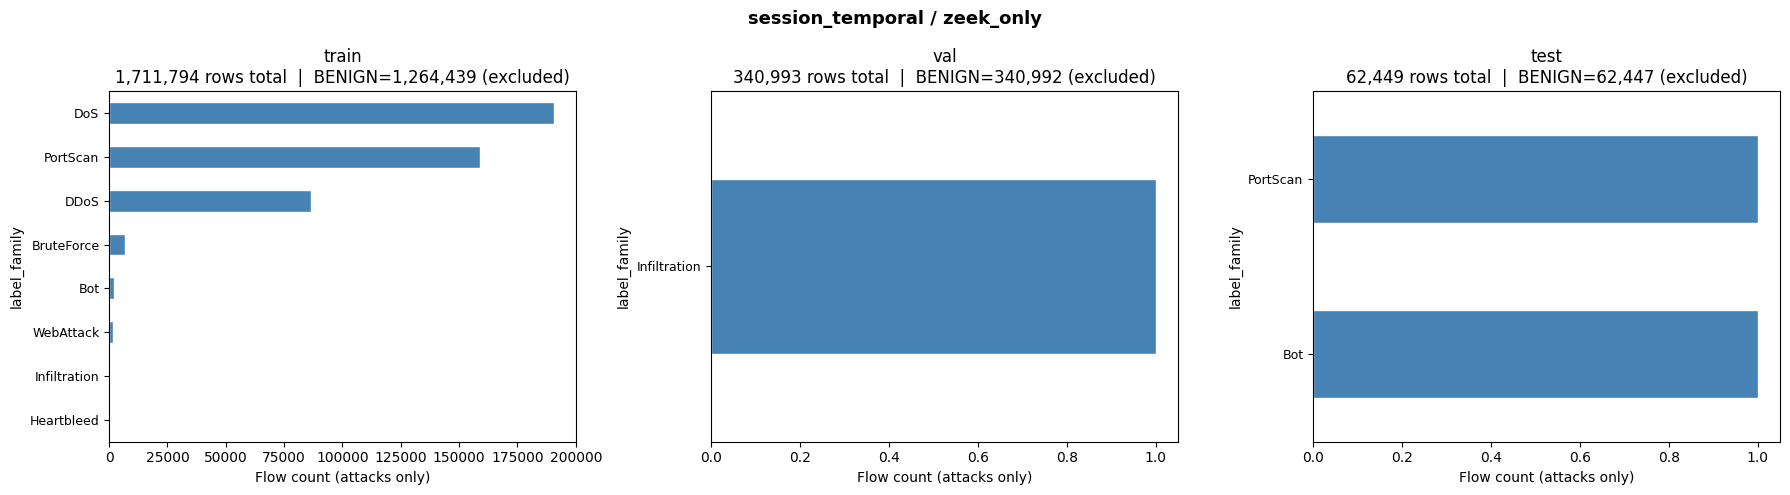

[+] Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_session_temporal_-_zeek_only.png


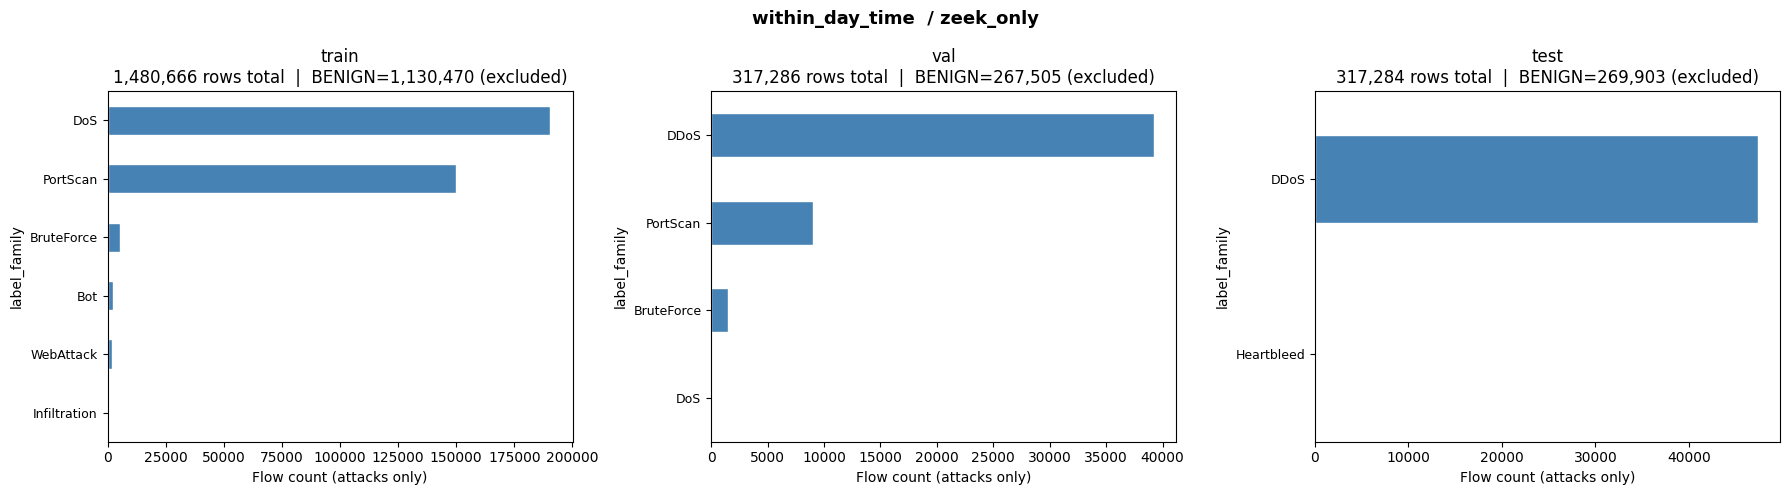

[+] Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_within_day_time__-_zeek_only.png


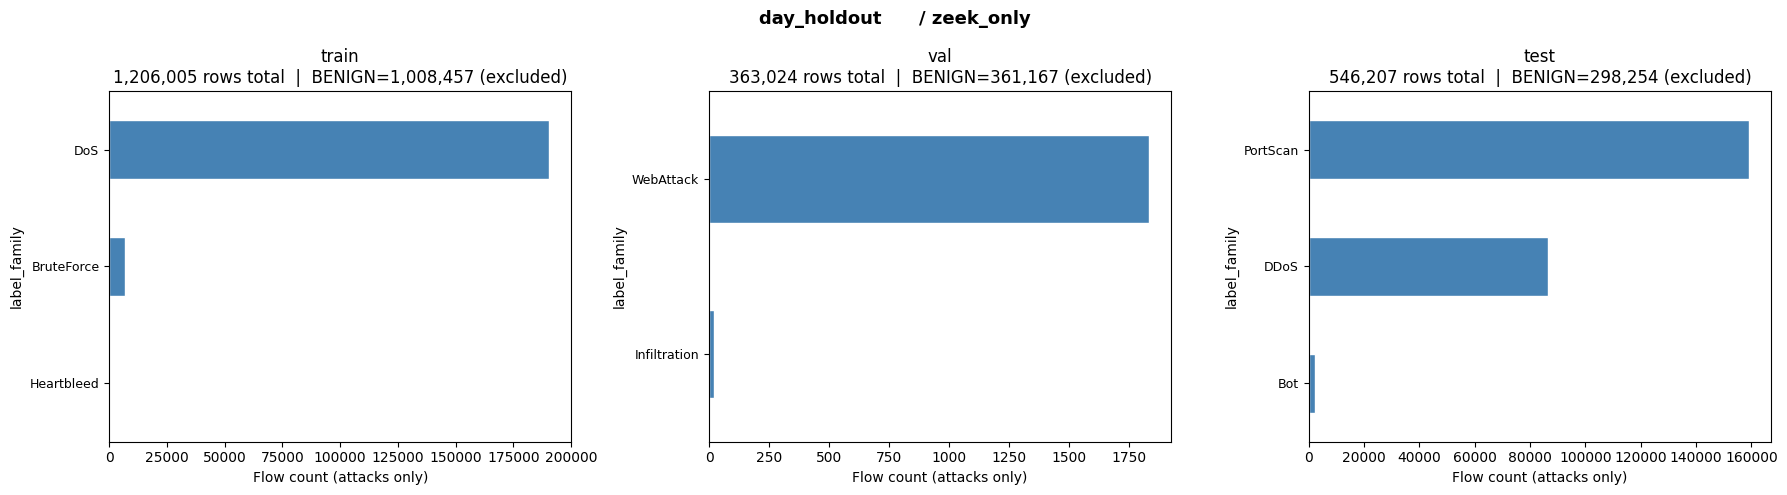

[+] Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_day_holdout______-_zeek_only.png


In [26]:
def plot_label_dist(splits_dir: Path, title: str):
    splits_dir = Path(splits_dir)
    if not (splits_dir / "train.parquet").exists():
        print(f"[!] Skipping {title}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, split in zip(axes, ["train", "val", "test"]):
        df = pd.read_parquet(splits_dir / f"{split}.parquet", columns=["label_family"])
        total_rows = len(df)
        benign_n   = (df["label_family"] == "BENIGN").sum()

        # Exclude BENIGN — it dominates the scale and hides attack distribution
        vc = df["label_family"].value_counts().drop("BENIGN", errors="ignore")
        vc.sort_values().plot(kind="barh", ax=ax, color="steelblue", edgecolor="white")

        ax.set_title(f"{split}\n{total_rows:,} rows total  |  BENIGN={benign_n:,} (excluded)")
        ax.set_xlabel("Flow count (attacks only)")
        ax.tick_params(axis="y", labelsize=9)
        del df

    gc.collect()
    fig.suptitle(title, fontsize=13, fontweight="bold")
    plt.tight_layout()
    safe = title.replace(" ", "_").replace("/", "-")
    out = REPORTS_DIR / f"label_dist_{safe}.png"
    plt.savefig(out, dpi=130, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"[+] Saved: {out}")

plot_label_dist(SPLITS_SESSION_TEMPORAL_BASELINE, "session_temporal / zeek_only")
plot_label_dist(SPLITS_WITHIN_DAY_BASELINE,        "within_day_time  / zeek_only")
plot_label_dist(SPLITS_DAY_HOLDOUT_BASELINE,       "day_holdout      / zeek_only")
